##Index

* [Initial Configurations](#configs)
* ####Patterns
  * [Parent references](#parent_references)
  * [Child references](#child_references)
  * [Materialized Paths](#materialized_paths)
  * [Nested Sets](#nested_sets) 

##Metodología

### Sobre el Dataset
El dataset fue obtenido, el día 25 de junio del 2015, del servicio de libros electónicos "Cambridge Books Online" creado por la "Cambridge University Press (CUP)" la casa editorial más antigua y la segunda editorial universitaria más grande en el mundo después de la Editorial de la Universidad de Oxford. Este conjunto de datos  http://ebooks.cambridge.org/download?f=titlelist_csv&prodCode=CBO&type=titlelist contiene 20242 registros de los cuales luego con la herramienta de hoja de cálculo Libre Office Calc:
1. Se filtraron unicamente aquellos que pertenecen a la categoría de "Ciencias de la Computación" para luego obtener un dataset definitivo de 297 títulos y 3 columnas (Titulo del libro, Categría y Subcategoría).
2. Se realizó la limpieza de algunos datos, especialmente en lo que tiene que ver con la eliminación de espacios duplicados.

![Dataset](./images/dataset.png)

##Conclusiones y Resultados

* La librería python para Análisis de Datos Pandas permite procesar cómodamente datos jerárquicos
* Al aplicar el patron Child References se tuvo problemas de repetición de datos en el segundo nivel del árbol
* El modelamiento de datos relacionales o categorizados en estructuras jerárquicas como los árboles pasa por modelar jerárquicamente en primer lugar.

##Trabajos Futuros

* Automatizar el proceso de inserción de la estructura arbol en la base de datos MongoDB utilizando por ejemplo la libreria ete2 para procesamiento de estructuras de árbol.
* Usar la libreria pytables en el caso de tener datos realmente grandes y mapear al formato HDF5

**Prerequisitos de Software para la experimentación:**
    * MongoDB 3.0.4 (on MongoLab cloud)
    * pymongo 3.02
    * Python 3.4
    * Pandas 0.16.2

<a id="configs"><h2> Configuraciones iniciales </h2></a>

In [4]:
import pandas as pd
from pymongo import MongoClient
from configparser import ConfigParser
import unittest

# First copy 'config.ini.tmpl' to 'config.ini' and set the MongoDB database credentials
conf = ConfigParser()
conf.read('config.ini')
experiments = list()

def load():
    """ Load the dataset en returns a pandas.DataFrame """
    data = pd.read_csv('datasets/cambridge-cs-titles.csv', dtype={'eISBN': str})
    return data

def connect():
    """ Connect to MongoDB database and return a object reference this connection """
    uri = 'mongodb://{0}:{1}@{2}:{3}/library'.format(
            conf.get('database', 'user'), conf.get('database', 'password'), 
            conf.get('database', 'host'), conf.get('database', 'port'))
    client = MongoClient(uri)
    db = client['library']
    return db

<a id="parent_references"> <h2> Model Tree Structures with Parent References (Parent Links) </h2> </a> 
<p/>
Almacena cada nodo del árbol en un documento; adicionalmente a la información del nodo del árbol el documento almacena el 'id' del nodo padre.

In [2]:
class ParentReferences(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        db = connect()
        db.subjects1.drop()
        
    def setUp(self):
        self.db = connect()
        self.data = load()

    def test_insert(self):
        db = self.db
        data = self.data
        db.subjects1.drop()
        # Setting dataframe multiindex
        data = data.set_index(['MainSubject', 'SubSubject'])
        data.index.sortlevel()

        # Store titles with parent reference
        for indexes, row in data.iterrows():
            db.subjects1.insert( { '_id': str(row['eISBN']), 'name': row['Title'], 'parent': indexes[1] } )

        # Store subsubjects with parent reference
        for mainsubject, subsubject in data.index.unique():
            db.subjects1.insert( { "_id": subsubject, "parent": mainsubject } )

        # Store mainsubject with parent (root) reference
        for mainsubject in data.index.levels[0]:
            db.subjects1.insert( { '_id': mainsubject, 'parent': 'eBooks Cambridge'})
        
        assert db.subjects1.count() == 313

    def test_indexing(self):
        result = self.db.subjects1.create_index('parent')
        assert result == 'parent_1'
        
    def test_query(self):
        result = self.db.subjects1.find_one({'_id': '9781139084789'}).get('parent')
        assert result == 'Knowledge management'
        
    def test_query_by_index(self):
        children = self.db.subjects1.find({'parent' : 'Knowledge management'})
        assert children.count() > 0

In [5]:
ParentReferences.setUpClass()
pattern1 = ParentReferences()
pattern1.setUp()
t1 = %timeit -o pattern1.test_insert()
t2 = %timeit -o pattern1.test_query()
t3 = %timeit -o pattern1.test_indexing()
t4 = %timeit -o pattern1.test_query_by_index()
times = [r.best for r in (t1, t2, t3, t4)]
experiments.append(['Parent References'] + times)

1 loops, best of 3: 32.7 s per loop
10 loops, best of 3: 100 ms per loop
10 loops, best of 3: 100 ms per loop
10 loops, best of 3: 101 ms per loop


| Pros        | Cons           
| ------------- |:-------------:|
| Consulta para recuperar el padre de un nodo más rápida y sencilla|   |
| Provee una solución simple para el almacenamiento | Se requiere múltimples consultas para recuperar subárboles|
| Se puede crear un índice sobre el campo 'parent' para permitir búsquedas rápidas |       |
|||
|Se puede consultar por el campo 'parent' para encontrar inmediatamente los nodos hijos |       |

<a id="child_references"><h2> Model Tree Structures with Child References </h2> </a>

El patrón "Child References" almacena cada nodo del árbol en un documento; adicionalmente a la información del nodo de árbol, el documento almacena en un arreglo los id(s) de los nodos hijos.

In [6]:
class ChildReferences(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        db = connect()
        db.subjects2.drop()

    def setUp(self):
        self.db = connect()
        self.data = load()    

    def test_insert(self):
        db = self.db #alias
        data = self.data #alias
        db.subjects2.drop()
        # Setting dataframe multiindex
        data = data.set_index(['MainSubject', 'SubSubject'])
        data.index.sortlevel()

        # Store titles  whitout chlidren
        titles = data[['Title', 'eISBN']]
        for indexes, row in titles.iterrows():
            db.subjects2.insert( {'_id': row['eISBN'], 'name': row['Title'], 'children': [] } )

        # Store the subsubject with your titles children
        for mainsubject, subsubject in data.index.unique():
            # Get all titles in this subsubject
            children = data.ix[(mainsubject, subsubject)]['eISBN'].tolist()
            db.subjects2.insert( { "_id": subsubject, "children": children } )

        # Store the mainsubject with your subsubjects children
        mainsubject = data.index.levels[0][0]
        subsubjects = data.index.levels[1].tolist()
        db.subjects2.insert( { "_id": mainsubject, "children": subsubjects } )

        # Store the root with mainsubject children
        db.subjects2.insert( { "_id": "eBooks Cambridge", "children": [mainsubject] } )
        
        assert db.subjects2.count() == 314

    def test_indexing(self):
        result = self.db.subjects2.create_index("children")
        assert result == 'children_1'
    
    def test_query(self):
        result = self.db.subjects2.find_one( { "_id": "Knowledge management" } ).get("children")
        assert result is not None and '9781139084789' in result
            
    def test_query_by_index(self):
        result = self.db.subjects2.find( { "children":  ["9780511583919", "9780511547065"] } )
        assert result.count() > 0

In [7]:
ChildReferences.setUpClass()
pattern2 = ChildReferences()
pattern2.setUp()
t1 = %timeit -o pattern2.test_insert()
t2 = %timeit -o pattern2.test_query()
t3 = %timeit -o pattern2.test_indexing()
t4 = %timeit -o pattern2.test_query_by_index()
times = [r.best for r in (t1, t2, t3, t4)]
experiments.append(['Child References'] + times)

1 loops, best of 3: 38.7 s per loop
10 loops, best of 3: 101 ms per loop
10 loops, best of 3: 100 ms per loop
10 loops, best of 3: 101 ms per loop


/home/miltonlab/anaconda3/lib/python3.4/site-packages/pandas/core/index.py:5091: PerformanceWarning: indexing past lexsort depth may impact performance.
  PerformanceWarning)


| Pros        | Cons           
| ------------- |:-------------:|
| La consulta para recuperar los hijos inmediatos de un nodo es más rápida y sencilla |   |
| Se puede crear un índice sobre el campo 'children' para permitir búsquedas rápidas por los nodos hijos| |
| Se puede consultar por un nodo en el campo 'children' para encontrar su *nodo padre así como sus nodos hermanos* |       |
|||
|Provee una solución adecuada para almacenamiento de árboles siempre y cuando no sean necesarias las operaciones en subárboles||
|Puede proveer una solución adecuada para almacenar grafos donde un nodo puede tener múltiples padres||

<a id="array_ancestors"><h2> Model Tree Structures with an Array of Ancestor </h2> </a>

El patrón "Arreglo de Ancestros" almacena cada nodo del árbol en un documento; adicionalmente al nodo de árbol, el documento almacena en un arreglo los id(s) de los nodos ancestros o camino.

In [14]:
class ArrayAncestors(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        db = connect()
        db.subjects3.drop()

    def setUp(self):
        self.db = connect()
        self.data = load()    

    def test_insert(self):
        db = self.db
        data = self.data
        db.subjects3.drop()
        # Setting dataframe multiindex
        data = data.set_index(['MainSubject', 'SubSubject'])

        # Store titles with ancestors from iterrows index
        for indexes, row in data.iterrows():
            db.subjects3.insert( { "_id": row["eISBN"],
                                "name": row["Title"],
                                "ancestors": ["eBooks Cambride", indexes[0], indexes[1]],
                                "parent": indexes[1]
                                } )
        
        # Store subsubjects with ancestors from index level 1
        for subsubject in data.index.levels[1].tolist():
            db.subjects3.insert( { "_id": subsubject, 
                                  "ancestors": ["eBooks Cambridge", data.index.levels[0][0]], 
                                  "parent": data.index.levels[0][0]
                                  } )

        # Store mainsubject with ancestor
        db.subjects3.insert( { "_id": data.index.levels[0][0], 
                             "ancestors": ["eBooks Cambridge"], 
                             "parent": "eBooks Cambridge" 
                             } )

        # Store the root
        db.subjects3.insert( { "_id": "eBooks Cambridge", "ancestors": [], "parent": None } )
        
        assert db.subjects3.count() == 314
        
    def test_query(self):
        result = self.db.subjects3.find_one( { "_id": "Knowledge management" } ).get("ancestors")
        assert result is not None and "Computer science" in result
    
    def test_indexing(self):
        result = self.db.subjects3.create_index("ancestors")
        assert result == 'ancestors_1'

    def test_query_by_index(self):
        result = self.db.subjects3.find( { "ancestors": ["eBooks Cambride", 
                                                         "Computer science", 
                                                         "IT management and e-commerce"]
                                          } )
        assert result.count() > 0

In [15]:
ArrayAncestors.setUpClass()
pattern3 = ArrayAncestors()
pattern3.setUp()
t1 = %timeit -o pattern3.test_insert()
t2 = %timeit -o pattern3.test_query()
t3 = %timeit -o pattern3.test_indexing()
t4 = %timeit -o pattern3.test_query_by_index()
times = [r.best for r in (t1, t2, t3, t4)]
experiments.append(["Array Ancestors"] + times)

1 loops, best of 3: 32.1 s per loop
10 loops, best of 3: 99.6 ms per loop
1 loops, best of 3: 99.7 ms per loop
10 loops, best of 3: 101 ms per loop


| Pros        | Cons           
| ------------- |:-------------:|
| | Adicionalmente al campo "ancestors" se necesita almacenar la referencia a la categoría del padre inmediata en el campo 'parent' |
| La consulta para recuperar los ancestros o el camino de un nodo es rápida y sencilla| |
| Se puede crear un índice sobre el campo 'ancestors' para permitir búsquedas rápidas por los nodos ancestros|       |
|Se puede consultar por el campo 'ancestros' para encontrar todos sus **descendientes**||
|||
|El patrón "Array of Ancestors" provee una solución rápida y eficiente para encontrar todos los descendientes y los ancestros de un nodo creando un índice sobre los elementos del campo 'ancestors'. Esto hace a este patrón una buena elección para trabajar con subárboles ||
||Este patrón es ligeramente más lento que el patrón "Materialized Paths" pero es más sencillo de usar|

<a id="materialized_paths"><h2> Model Tree Structures with Materialized Paths (Views) </h2> </a>

<a id="materialized_paths"/>

Este patrón almacena cada nodo del árbol en un documento; adicionalmente al nodo de árbol, el documento almacena en forma de un string los ids(s) de los nodos ancestros o camino. 
Aunque el patrón "Materialized Paths" requiere pasos adicionales de trabajo con strings y expresiones regulares, el patrón también provee más flexibilidad en el trabajo con el camino, tales como la búsqueda de nodos por caminos parciales. 

In [16]:
class MaterializedPaths(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        db = connect()
        db.subjects4.drop()

    def setUp(self):
        self.db = connect()
        self.data = load()    

    def test_insert(self):
        db = self.db #alias
        data = self.data #alias
        db.subjects4.drop()
        data = data.set_index(['MainSubject', 'SubSubject'])

        # Store titles with ancestors from iterrows index
        for indexes, row in data.iterrows():
            db.subjects4.insert( { "_id": row["eISBN"],
                                "name": row["Title"],
                                "path": ','.join(["", "eBooks Cambride", indexes[0], indexes[1], ""]),
                                } )
        # Store subsubjects with ancestors from index levels
        for subsubject in data.index.levels[1].tolist():
            db.subjects4.insert( { "_id": subsubject, 
                                 "path": ",".join(["", "eBooks Cambridge", data.index.levels[0][0], ""])
                                })
        # Store mainsubject with ancestor
        db.subjects4.insert( {"_id": data.index.levels[0][0], 
                             "path": ",".join(["","eBooks Cambridge",""])
                             })
        # Store the root
        db.subjects4.insert( { "_id": "eBooks Cambridge", "path": ""})
        assert db.subjects3.count() == 314
        
    def test_query(self):
        result = self.db.subjects4.find_one( { "_id": "Knowledge management" } )
        # Find Descendents of one document
        # result = self.db.subjects4.find_one( { "path": {"$regex": r",Knowledge management," } } )
        assert result is not None and result["_id"] == "Knowledge management"
    
    def test_indexing(self):
        result = self.db.subjects4.create_index("path")
        assert result == 'path_1'

    def test_query_by_index(self):
        # Find the desendents of IT management and e-commerce
        result = self.db.subjects4.find( { "path": {"$regex": r",IT management and e-commerce,"} } )
        assert result.count() > 0 
        
    def test_other(self):
        # Read all the tree sorted by path
        self.db.subjeects4.find().sort("path")
        # Read all the tree with regex
        self.db.subjects4.find( { "path": {"$regex": r"^,eBooks Cambridge," } } )   

In [17]:
MaterializedPaths.setUpClass()
pattern4 = MaterializedPaths()
pattern4.setUp()
t1 = %timeit -o pattern4.test_insert()
t2 = %timeit -o pattern4.test_query()
t3 = %timeit -o pattern4.test_indexing()
t4 = %timeit -o pattern4.test_query_by_index()
times = [r.best for r in (t1, t2, t3, t4)]
experiments.append(["Materialized Paths"] + times)

1 loops, best of 3: 33 s per loop
10 loops, best of 3: 102 ms per loop
The slowest run took 5.25 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 102 ms per loop
10 loops, best of 3: 103 ms per loop


| Pros        | Cons           
| ------------- |:-------------:|
| Se puede realizar la consulta para recuperar ordenàndolo por el campo 'path' |  |
| Se puede usar expresiones regulares sobre el campo 'path' para encontrar por ejemplo los descendientes de un nodo | |
| Habilita el uso de índices sobre el campo 'path' al tratarlo como string |       |
| Las consultas sobre el índice mejorarán significativamente o aparotarán alguna mejora dependiendo del tamaño que tenga el índice: mientras más pequeño más rápida será la consulta (**TODO: Probar 2 casos**) ||

<a id="nested_sets"><h2> Model Tree Structures with Nested Sets </h2> </a>

![Nested Sets](http://docs.mongodb.org/manual/_images/data-model-example-nested-set.png)

<a id="nested_sets"/>

El patrón "Nested Sets" identifica cada nodo en el árbol como señales "pare" en un recorrido de ida y vuelta del árbol. 
La aplicación visita cada nodo en el árbol 2 veces; la primera durate el viaje inicial y la segunda durante el viaje de retorno. 
Este patrón almacena cada nodo del árbol en un documento; adicionalmente a la información del nodo del árbol el documento almacena el id del nodo padre, los nodos parada inicial en el campo **left** y parada de retorno en el campo **right**. Es adecuado para árboles estáticos que no cambian.

In [19]:
class NestedSets(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        db = connect()
        db.subjects5.drop()

    def setUp(self):
        self.db = connect()
        self.data = load()    

    def test_insert(self):
        db = self.db #alias
        data = self.data #alias
        db.subjects5.drop()
        data = data.set_index(['MainSubject', 'SubSubject'])
        count = 1

        # Prestore the root
        dictroot = {"_id": "eBooks Cambridge", "parent": None, "left": count}
        count += 1

        # Prestore the Mainsubject
        dictmainsubject = { "_id": data.index.levels[0][0], "parent": dictroot["_id"], "left": count }
        count += 1

        # Prestore Subsubjects
        for subsubject in data.index.levels[1].tolist():
            mainsubject = data.index.levels[0][0]
            dictsubsubject = { "_id": subsubject, "parent": dictmainsubject["_id"], "left": count }
            count += 1

            # Prestore titles belong to subsubject quering by subsubject and mainsubject
            titles = data.ix[(mainsubject, subsubject)]
            for index, row in titles.iterrows():
                dicttitle = { "_id": row["eISBN"], "name": row["Title"], "parent": subsubject, "left": count }
                count += 1
                dicttitle["right"] = count
                db.subjects5.insert( dicttitle )
                count += 1
            dictsubsubject["right"] = count
            db.subjects5.insert( dictsubsubject )
            count += 1
        dictmainsubject["right"] = count
        db.subjects5.insert( dictmainsubject )
        count += 1
        dictroot["right"] = count
        db.subjects5.insert( dictroot )
        assert db.subjects5.count() == 314

    def test_query(self):
        title = self.db.subjects5.find_one( { "_id": "9781139084789" } )
        assert title and title["right"] == title["left"] + 1
    
    def test_indexing(self):
        result = self.db.subjects5.create_index( [("left", 1), ("right", 1)] )
        assert result == 'left_1_right_1'

    def test_query_by_index(self):
        # Find the children of "IT management and e-commerce"
        subsubject = self.db.subjects5.find_one( { '_id': 'IT management and e-commerce' } )
        titles = self.db.subjects5.find( {"left" : {"$gt": subsubject["left"] }, 
                                          "right": {"$lt": subsubject["right"] }
                                          } )
        assert titles.count() > 0 
        
    def test_other(self):
        assert True

In [20]:
NestedSets.setUpClass()
pattern5 = NestedSets()
pattern5.setUp()
t1 = %timeit -o pattern5.test_insert()
t2 = %timeit -o pattern5.test_query()
t3 = %timeit -o pattern5.test_indexing()
t4 = %timeit -o pattern5.test_query_by_index()
times = [r.best for r in (t1, t2, t3, t4)]
experiments.append(["Nested Sets"] + times)

1 loops, best of 3: 32.7 s per loop
10 loops, best of 3: 100 ms per loop
1 loops, best of 3: 100 ms per loop
1 loops, best of 3: 202 ms per loop


/home/miltonlab/anaconda3/lib/python3.4/site-packages/pandas/core/index.py:5091: PerformanceWarning: indexing past lexsort depth may impact performance.
  PerformanceWarning)


| Pros        | Cons           
| ------------- |:-------------:|
| Provee una solució rápida y eficiente para la encontrar subárboles |  |
| | Ineficiente cuando se trarta de operaciones de modificación del árbol|


In [1]:
import seaborn
import pandas as pd
#
#Only for test
experiments = pd.DataFrame({'pattern': pd.Series(['Patron 1','Patron 2', 'Patron 3', 'Patron 4', 'Patron 5']), 
                           't1': pd.Series([5,4,5,6,4]),
                           't2': pd.Series([15,4,5,6,4]),
                           't3': pd.Series([5,24,5,6,4]),
                           't4': pd.Series([5,4,35,64,4])})

In [24]:
results = pd.DataFrame(experiments)

In [31]:
results.to_pickle('results.pck')

# AQUI

In [10]:
########import pandas as pd
###%matplotlib inline

In [3]:
results = pd.read_pickle('results.pck')

In [18]:
results.columns = ("Pattern", 'Insert', 'Query', 'Index_creation', 'Query_index')

In [19]:
results

,Pattern,Insert,Query,Index_creation,Query_index
0,Parent References,32.726743,0.100236,0.100369,0.100881
1,Child References,38.651602,0.101233,0.100354,0.100594
2,Array Ancestors,32.072196,0.099560,0.099695,0.100783
3,Materialized Paths,33.027615,0.102230,0.101880,0.102662
4,Nested Sets,32.675157,0.100048,0.100155,0.202063


In [9]:
import seaborn as sea

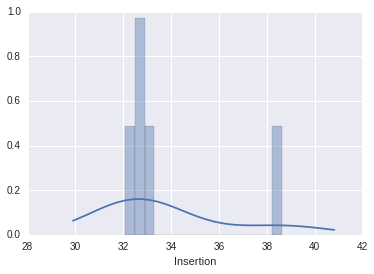

In [14]:
sea.set_style("darkgrid")
sea.distplot(results.Insertion)

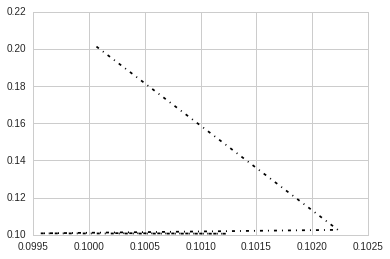

In [44]:
sea.set_style("whitegrid")
#sea.distplot(results.Insert)
g = sea.plt.plot(results.Query, results.Query_index, 'k-.')#, results.Insert, results.Index_creation, 'k--')
#sea.jointplot(results.Query, results.Query_index)